In [4]:
# pip install transformers
from transformers import AutoModelForCausalLM, AutoTokenizer
checkpoint = "HuggingFaceTB/SmolLM2-135M"
device = "cpu" # for GPU usage or "cpu" for CPU usage
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
# for multiple GPUs install accelerate and do `model = AutoModelForCausalLM.from_pretrained(checkpoint, device_map="auto")`
model = AutoModelForCausalLM.from_pretrained(checkpoint).to(device)
inputs = tokenizer.encode("Gravity is", return_tensors="pt").to(device)
outputs = model.generate(inputs)
print(tokenizer.decode(outputs[0]))


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Gravity is the force that holds the Earth and the Moon together.

The Moon is a satellite of the


In [8]:
print(model.config)

LlamaConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "HuggingFaceTB/SmolLM2-135M",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "eos_token_id": 0,
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 576,
  "initializer_range": 0.041666666666666664,
  "intermediate_size": 1536,
  "is_llama_config": true,
  "max_position_embeddings": 8192,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 9,
  "num_hidden_layers": 30,
  "num_key_value_heads": 3,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_interleaved": false,
  "rope_scaling": null,
  "rope_theta": 100000,
  "tie_word_embeddings": true,
  "torch_dtype": "bfloat16",
  "transformers_version": "4.48.0",
  "use_cache": true,
  "vocab_size": 49152
}



In [6]:
print(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(49152, 576)
    (layers): ModuleList(
      (0-29): 30 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=576, out_features=576, bias=False)
          (k_proj): Linear(in_features=576, out_features=192, bias=False)
          (v_proj): Linear(in_features=576, out_features=192, bias=False)
          (o_proj): Linear(in_features=576, out_features=576, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=576, out_features=1536, bias=False)
          (up_proj): Linear(in_features=576, out_features=1536, bias=False)
          (down_proj): Linear(in_features=1536, out_features=576, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((576,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((576,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((576,), eps=1e-05)
    (rotary_emb): LlamaRotaryEm

## Deductions from the model info above
1. The model is a GPT-2 like model with 30 layers, 9 heads, and 576 embedding dimensions.
2. The model has activation function of Silu.
3. The model has a vocabulary size of 49152.
4. Max positional embeddings is 8192
4. The model has a attention dropout rate of 0.0
5. The model uses RMSNorm for layer normalization instead of LayerNorm.
6. Model uses Rotary Embeddings for positional embeddings
7. the Hidden dimension of the mlp is 1536

In [9]:
import torch
import torch.nn as nn
rms_norm = nn.RMSNorm([2, 3])
input = torch.randn(2, 2, 3)
output = rms_norm(input)
print(output)

tensor([[[-1.1019,  0.3272, -0.2194],
         [-1.0659,  0.7419, -1.7158]],

        [[ 0.3353, -2.1515,  0.0805],
         [ 0.7911, -0.7218,  0.3248]]], grad_fn=<MulBackward0>)


In [12]:
from model import SmolLM, SmolLMConfig
config = SmolLMConfig()
model = SmolLM(config, use_rms_norm=True)
print(model)

SmolLM(
  (wte): Embedding(49152, 576)
  (wpe): Embedding(1024, 576)
  (drop): Dropout(p=0.1, inplace=False)
  (blocks): ModuleList(
    (0-29): 30 x DecoderBlockWithLayerNorm(
      (ln_1): LayerNorm((576,), eps=1e-05, elementwise_affine=True)
      (attn): CausalMultiHeadAttention(
        (c_attn): Linear(in_features=576, out_features=1728, bias=True)
        (c_proj): Linear(in_features=576, out_features=576, bias=True)
        (attn_dropout): Dropout(p=0.0, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((576,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (c_fc): Linear(in_features=576, out_features=1536, bias=True)
        (silu): SiLU()
        (c_proj): Linear(in_features=1536, out_features=576, bias=True)
      )
    )
  )
  (ln_f): LayerNorm((576,), eps=1e-05, elementwise_affine=True)
  (lm_head): Linear(in_features=576, out_features=49152, bias=False)
)


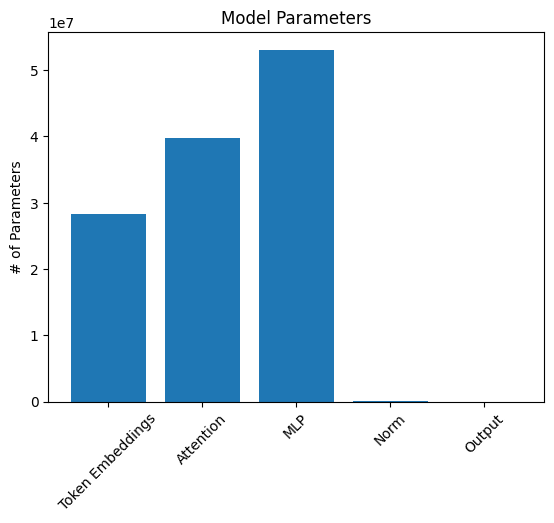

Token Embeddings               28,311,552      23.35%
Attention                      39,813,120      32.84%


ValueError: Unknown format code 'd' for object of type 'float'

In [13]:
# Some working statistics

# Model
vocabulary_size = SmolLMConfig.vocab_size
embedding_dimensions = SmolLMConfig.n_embed
num_attention_heads = SmolLMConfig.n_heads
num_hidden_layers = SmolLMConfig.n_layers
feed_forward_ratio = SmolLMConfig.mlp_hidden_dim / SmolLMConfig.n_embed

import matplotlib.pyplot as plt

parameter_counts = {
    "Token Embeddings": vocabulary_size * embedding_dimensions,
    "Attention": (
        embedding_dimensions * 3 * embedding_dimensions + embedding_dimensions**2
    ) * num_hidden_layers,
    "MLP": (
        embedding_dimensions * feed_forward_ratio * embedding_dimensions * 2
    ) * num_hidden_layers,
    "Norm": embedding_dimensions * 2 * num_hidden_layers + embedding_dimensions,
    "Output": 0, # We share the embedding weights
}

plt.bar(parameter_counts.keys(), parameter_counts.values())

plt.title("Model Parameters")
plt.ylabel("# of Parameters")
plt.xticks(rotation=45)

plt.show()

total_parameter_count = sum(parameter_counts.values())

for name, count in parameter_counts.items():
    print(f"{name:20s} {count:20,d} {count / total_parameter_count * 100:10.2f}%")


print(f"Total parameters: {total_parameter_count:,}")